# EPSRC: AI Skills Through Music 🤖🎹

© 2025, [Dr. Huw Cheston](https://huwcheston.github.io), Queen Mary University of London

## Useful Links 🔗

- Documentation for the [`numpy` Python package](https://numpy.org/doc/)
- Documentation for [`librosa`](https://librosa.org/)
- An introduction to [tempo estimation and beat tracking](https://www.youtube.com/watch?v=FmwpkdcAXl0)
- A guide to [permutation feature importance by the `scikit-learn` developers](https://scikit-learn.org/stable/modules/permutation_importance.html)


# 3. Evaluation and Interpretability 🤔

In the **previous notebook**, we explored two different learning paradigms in machine learing:
1. **Unsupervised Learning**
2. **Supervised Learning**

In particular, we saw how we can **evaluate a supervised learning model** by considering the **accuracy of its predictions**. However, **accuracy** is only one way to measure how well a model performs. Sometimes, a model can have a high accuracy overall but still make important mistakes. Relying solely on accuracy could cause us to **misunderstand how well the model works**.

In this notebook, we will go beyond accuracy and explore **other evaluation metrics** that help us better understand a model's performance, such as:  
- **Precision**
- **Recall**  
- **F1 Score**

We'll also explore other ways of **interpreting a model's predictions**, including:
- **Confusion Matrices**
- **Feature Importances**

These tools give us a more detailed view of **what kinds of predictions the model is getting right or wrong**.  

<img src="https://miro.medium.com/v2/resize:fit:1400/0*3nrQZi2vZIDg6xhU.png" width="600px"/>




In [53]:
# @title
!wget https://github.com/musicinformationretrieval/musicinformationretrieval.com/raw/refs/heads/gh-pages/mirdotcom/assets/audio/prelude_cmaj.wav
!pip install mir_eval mirdata

import librosa
import matplotlib.pyplot as plt
import mirdata
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import IPython.display as ipd
from joblib import Parallel, delayed
from mir_eval.onset import f_measure
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tqdm import tqdm

--2025-11-14 10:29:58--  https://github.com/musicinformationretrieval/musicinformationretrieval.com/raw/refs/heads/gh-pages/mirdotcom/assets/audio/prelude_cmaj.wav
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/musicinformationretrieval/musicinformationretrieval.com/refs/heads/gh-pages/mirdotcom/assets/audio/prelude_cmaj.wav [following]
--2025-11-14 10:29:58--  https://raw.githubusercontent.com/musicinformationretrieval/musicinformationretrieval.com/refs/heads/gh-pages/mirdotcom/assets/audio/prelude_cmaj.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 348434 (340K) [audio/wav]
Saving to: ‘p

## Evaluation 📈

Watch the video below. In what ways are the lights **responding to the music**?

<video width="640" height="480" controls>
  <source src="https://packaged-media.redd.it/quay2yfggbv51/pb/m2-res_1080p.mp4?m=DASHPlaylist.mpd&v=1&e=1763046000&s=f3edbe2891a2a78abc604801f9edac6d8f2c913b" type="video/mp4">
Your browser does not support the video tag.
</video>

### Introducing Beat Tracking 🥁


You might have noticed that the lights are moving in response to the **beat** of the music.

> In music, the **beat** usually relates to the *pulse*: it's what you'd tap your foot or nod your head to. In many forms of music, the beat is usually **periodic** and **regular**, with a similar amount of time passing from one beat to the next.

Under the hood, these lights are connected to a computer running Python code that **detects the beats** of a piece of music in real time. It then sends this information to another controller that **automates turning the lights on and off** in response to the beats.

We can use an algorithm or machine learning model to perform this task of beat tracking. But **how do we know if the model is performing well?** One way is simply to listen to and look at the results. But a more systematic way is to conduct a **formal statistical evaluation**.

Our beat tracker is simply a **classifier** that, given a frame of audio, **predicts whether it contains a beat**. As a result, we could give the output of our model as a binary sequence, like this:

`[0, 0, 0, 1, 0, 0, 0, 1]`

where 1 suggests that the frame contains a beat, and 0 suggests that it does not contain a beat.

We could also collapse this lengthy sequence into a one-dimensional, discrete sequence, where every value is the number of a frame containing a beat. For example:

`[5, 10, 15, 21]`

suggests that frames **5, 10, 15, and 21** contain beats. These would be the indices of values **containing a 1** in our binary sequence.

If we know the sample rate and distance between frames, we can convert these **back into timestamps**. For example:

`[0.1, 0.8, 1.2, 1.6]`

suggest that there are beats occurring at **0.1, 0.8, 1.2, and 1.6 seconds**.

> **Tip:** if you are unsure what is meant by **sample rate**, check out the notebook on **Data Representations**.

#### Loading in a Recording 🎵

Let's start by loading in a recording with `librosa`:


In [2]:
y, sr = librosa.load("prelude_cmaj.wav")
ipd.Audio(y, rate=sr)

### Ground Truth 🧠

Recall from the previous notebook that, in order to measure the **accuracy** of a classifier, we need to know the actual, **true labels** - the ground truth.

For a **beat tracker**, the ground truth is the **actual location of the beats in the music**. Here are the actual beat positions for the audio we just loaded:

In [3]:
ground_truth_beats = np.array(
    [
        0.005,
        0.515,
        1.025,
        1.531,
        1.991,
        2.481,
        2.971,
        3.432,
        3.912,
        4.413,
        4.892,
        5.383,
        5.852,
        6.333,
        6.823,
        7.295,
        7.712,
    ]
)

#### Displaying Beats 🎨

Let's display the beats against a **magnitude spectrogram** of the audio.

> **More information**: if you're not sure what a **spectrogram** is, refer to the **Data Representations** notebook.

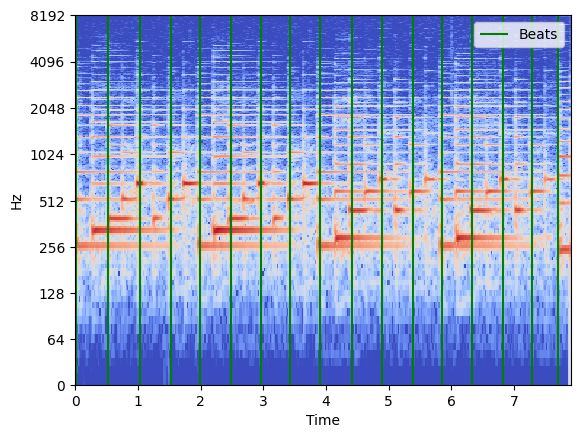

In [4]:
D = librosa.stft(y)
S = abs(D)
S_db = librosa.amplitude_to_db(S)
librosa.display.specshow(S_db, sr=sr, x_axis="time", y_axis="log")
plt.vlines(ground_truth_beats, *plt.gca().get_ylim(), color="green", label="Beats")

plt.ylim(0, 8192)
plt.legend(loc="upper right")
plt.show()

From looking at the graph, we can see how the beats are **periodic** and **regular**: we have about two beats per second of audio.

We can also convert the beats to **clicks** and play them alongside the original audio.

In [5]:
clicks = librosa.clicks(
    times=ground_truth_beats, sr=sr, click_freq=1000, length=len(y)
)
ipd.Audio(y + clicks, rate=sr)

Great! We can hear how the **click track** makes the **pulse of the music** much easier to hear.

### Baseline Prediction 📠

We'll start with a simple baseline prediction that estimates beats occurring at a regular interval.

In [6]:
estimated_beats = np.linspace(0, int(len(y) / sr), 71)
print(estimated_beats[:3])

[0.  0.1 0.2]


#### Accuracy Calculation 🔢

Now, we *could* compute our accuracy by simply looking at whether the beat tracker **predicted one of the values in our ground truth**. We'd do the following:
- Iterate over every beat in `ground_truth_beats`
- If the beat appears in `estimated_beats`:
- Increase a counter by 1
- After iterating over all beats, compute accuracy as the final counter value, divided by the number of ground truth beats.

Alternatively, as an equation:
$$
\text{Accuracy} = \frac{1}{|G|} \sum_{b \in G} \mathbb{1}_{\{b \in E\}}
$$
where $G$ is the vector of ground-truth beats and $E$ is the vector of estimated beats.



In [7]:
counter = 0
for beat in ground_truth_beats:
    if beat in estimated_beats:
        counter += 1

accuracy = counter / len(ground_truth_beats)
print(accuracy)

0.0


#### Accuracy with Tolerance 🪟

Hold on - the accuracy of our beat tracker is 0%? This form of evaluation **might not be very fair.**

Recall that the values in our `estimated_beats` and `ground_truth_beats` sequences are **continuous**: they can take on any value. If we only consider **one to one matches**, we might be too harsh on our beat tracker.

Instead, we usually allow for a **tolerance** when evaluating the performance of time-dependent machine learning models. This can be considered a **window around which we allow the model to make mistakes**. For example, with a tolerance of $\pm$0.1 seconds, if the model estimated a beat at 7.4 seconds, but the **actual beat was at 7.5** seconds, we'd still **count this as a match**.

Let's repeat our accuracy calculation, but allowing for a tolerance:

In [8]:
tolerance = 0.05    # 50 ms tolerance default

counter = 0
for beat in ground_truth_beats:
    for est_beat in estimated_beats:
        if abs(beat - est_beat) <= tolerance:
            counter += 1
            break

accuracy = counter / len(ground_truth_beats)
print(accuracy)

0.8823529411764706


With that change, we can see that the accuracy of our estimated beats is actually 88.2%.

> **Try:** changing the value of `tolerance` in the cell above. How does it effect the overall accuracy?

#### Interpreting our Baseline 🧰

Let's try listening to the results of our beat tracker. With an accuracy of nearly 90%, the predicted beats ***should be nearly perfect, right?***

In [9]:
clicks_baseline = librosa.clicks(
    times=estimated_beats, sr=sr, click_freq=1000, length=len(y)
)
ipd.Audio(y + clicks_baseline, rate=sr)

***What just happened?*** 🤯🔥💣

Our evaluation promised **90% accuracy**. But the results sound awful! Let's try looking at the spectrogram, maybe that'll help us understand what's going on.


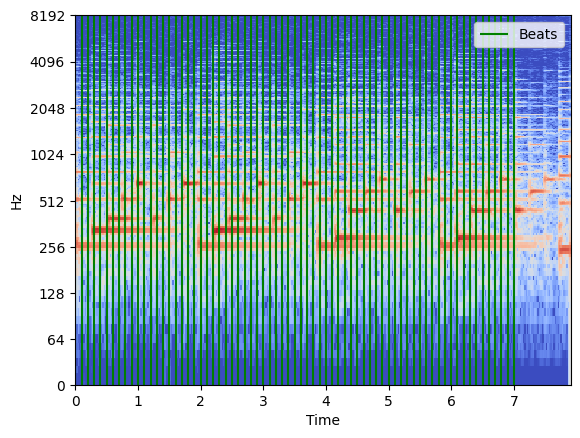

In [10]:
D = librosa.stft(y)
S = abs(D)
S_db = librosa.amplitude_to_db(S)
librosa.display.specshow(S_db, sr=sr, x_axis="time", y_axis="log")
plt.vlines(estimated_beats, *plt.gca().get_ylim(), color="green", label="Beats")

plt.ylim(0, 8192)
plt.legend(loc="upper right")
plt.show()

Hmm... If we look at the **predicted beats**, they seem to just be predicting that every possible timestamp is a beat. This leads to a **high accuracy**, as we are correctly predicting every beat in `ground_truth_beats`. We're also predicting a very large number of **incorrect beats**, too: but this isn't reflected in our final score.

So, it seems that using **accuracy** to evaluate our beat tracker **might be misleading!**

### Introducing Precision & Recall 📊

Instead of **accuracy**, we can introduce two additional metrics that are often used to evaluate machine learning classifiers. These are **precision** and **recall**.

#### True and False Positives and Negatives ➕➖

Before we can understand precision and recall, we need to understand what we mean by **true positives**, **false positives**, **true negatives**, and **false negatives**.

| Term | Meaning | Example |
|------|----------|------------------------|
| **True Positive (TP)** | A correct detection of something that exists. | A detected beat matches an actual beat. |
| **False Positive (FP)** | A detection that shouldn't have been made. | The tracker "hears" a beat where there is none. |
| **False Negative (FN)** | A missed detection of something that exists. | There was an actual beat, but the tracker didn't detect it. |
| **True Negative (TN)** | Correctly detecting that nothing is there. | No beat occurs, and the tracker stays silent. |

<img src="https://cdn.prod.website-files.com/65202a4cfee53d0589d8c6d5/66979ed4b122053d5e4dab3b_Screenshot%202024-05-10%20at%204.35.04%20PM.png" width="600px"/>

From looking at the table above, we can **hypothesise** that our beat tracker might have a high **false positive rate**. It frequently predicts *beat* for a frame that is *not a beat*.

> Vice-versa, a beat tracker that frequently **fails to detect correct beats** might have a high **false negative rate**.

We can calculate the exact value of each metric in Python. Let's start with **true positives**. We'll keep the same tolerance as before.

In [11]:
matched = np.zeros(len(estimated_beats), dtype=bool)
tp = 0

# Iterate over all ground truth beats
for gt in ground_truth_beats:

    # Calculate difference between this ground truth beat and all estimated beats
    diffs = np.abs(estimated_beats - gt)

    # Indices of estimated beats within the tolerance
    candidates = np.where(diffs <= tolerance)[0]

    if len(candidates) > 0:
        # Pick the closest estimated beat
        idx = candidates[np.argmin(diffs[candidates])]

        # If this beat hasn't already been matched, count as true positive
        if not matched[idx]:
            matched[idx] = True
            tp += 1

We can adapt that code to calculate **false positives** and **false negatives**:

In [12]:
tp_mask = np.zeros(len(estimated_beats), dtype=bool)

for gt in ground_truth_beats:
    # Compute differences between this ground truth beat and all estimated beats
    diffs = np.abs(np.array(estimated_beats) - gt)

    # Find estimated beats within the tolerance
    candidates = np.where(diffs <= tolerance)[0]

    if len(candidates) > 0:
        # Pick the closest estimated beat and mark it as matched
        idx = candidates[np.argmin(diffs[candidates])]
        tp_mask[idx] = True

# FPs are estimated beats that were not matched to any ground truth beat
fp = np.sum(~tp_mask)

In [13]:
tp_mask = np.zeros(len(ground_truth_beats), dtype=bool)

for i, gt in enumerate(ground_truth_beats):
    # Compute differences between this ground truth beat and all estimated beats
    diffs = np.abs(np.array(estimated_beats) - gt)

    # Find estimated beats within the tolerance
    candidates = np.where(diffs <= tolerance)[0]

    # If there is at least one close estimated beat, mark this ground truth beat as detected
    if len(candidates) > 0:
        tp_mask[i] = True

# Count false negatives: ground truth beats that were missed
fn = np.sum(~tp_mask)

In [14]:
print("N true positives: ", tp)
print("N false positives: ", fp)
print("N false negatives: ", fn)

N true positives:  15
N false positives:  56
N false negatives:  2


From looking at these results, we can see that our intuitions were correct: we detected **many more false positives** than we did **true positives** or **false negatives**.

#### Calculating Precision and Recall 🔢

Now that we've calculated the number of true positives, false positives, and false negatives, we can calcualate **precision** and **recall** simply with the below formulae:

$$
\text{Precision} = \dfrac{TP}{TP + FP}
$$

$$
\text{Recall} = \dfrac{TP}{TP + FN}
$$


> **Did you know?** Precision is often used to evaluate **retrieval** systems, such as **search engines** like Google and **recomendation systems** like Spotify and YouTube. However, we may modify this metric to use either the **mean average precision** (mAP) or the **precision @ $k$**. For more information, [see this article](https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)).

Let's calculate both **precision** and **recall** in Python.

In [15]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
print("Precision: ", precision)
print("Recall: ", recall)

Precision:  0.2112676056338028
Recall:  0.8823529411764706


OK: we can make the following conclusions from this evaluation:

- Our model scores **very high** for recall, meaning it rarely misses a real beat.
- Our model scores **very low** for precision, meaning it produces many extra detections that don't correspond to real beats.

You can think of our beat tracker as like a *student who raises their hand to answer every question* - whether or not they're right or wrong!

> **Question:** what would a beat tracker that scores **very high for precision**, but **very low for recall** look like?

<details>
<summary>Answer</summary>
A beat-tracker with high precision but low recall would only predict a small number of beats, but would be correct for most of them. Think of a student who rarely raises their hand to answer a question, but when they do, they're always right!
</details>

### F1-Score: Unifying Precision and Recall 🇫

The **F1-score** is a metric that combines **precision** and **recall** into a single value, providing a balance between them. It is especially useful when we want to account for both false positives and false negatives.

Mathematically, it is the [**harmonic mean**](https://en.wikipedia.org/wiki/Harmonic_mean) of precision and recall:

$$
F_1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

> **Did you know?** The harmonic mean is another kind of *average*, just like the **arithmetic mean** (which is the mean you are probably most familiar with!)

A high F1-score indicates that a model has both **high precision and high recall**, while a low F1-score shows that **either or both are lacking**.


In [16]:
fscore = 2 * (precision * recall) / (precision + recall)
print("F1-Score: ", fscore)

F1-Score:  0.34090909090909094


The F1-score provides a **much fairer** account of our beat tracker than any one of precision, recall, or accuracy. It takes into account the number of true positives, false positives, and false negatives.

For this reason, the F1-score is the **most commonly used metric** when evaluating many time-varying classification systems, including **beat tracking**. It is also commonly used for many other kinds of classifiers, too, including **genre and instrument classifiers**.

#### Checking our Work 🤓

We can check our calculations by using the `mir_eval` library. This has inbuilt functions for computing the $F1$, precision, and recall scores.

> **Important**: while `sklearn` also includes functions for calculating these metrics, it does not allow for a **tolerance to be set**, making it inappropriate for evaluating a beat tracker.

In [17]:
f, p, r = f_measure(ground_truth_beats, estimated_beats, window=tolerance)
print("mir_eval precision: ", p)
print("mir_eval recall: ", r)
print("mir_eval F1-score: ", f)

mir_eval precision:  0.2112676056338028
mir_eval recall:  0.8823529411764706
mir_eval F1-score:  0.34090909090909094


Great! We can see that our own measurements match up with those that we obtain using `mir_eval`.

### Evaluating a Real Beat Tracker 🤔

In the previous examples, we were computing `estimated_beats` simply by predicting that beats would occur at periodic, regular intervals. We didn't actually use an algorithm or machine learning model.

Let's change that. We'll process the same recording, but this time using the `librosa.beat_track` algorithm. We'll see how this affects the metrics we defined above, including **precision**, **recall**, and **F1-score**.

In [18]:
_, actual_estimated_beats = librosa.beat.beat_track(y=y, sr=sr, units="time")
print(actual_estimated_beats)

[0.55727891 1.021678   1.53251701 1.9969161  2.48453515 2.9721542
 3.43655329 3.90095238 4.41179138 4.89941043 5.38702948 5.85142857
 6.33904762 6.82666667 7.29106576 7.75546485]


To reduce the amount of code we need to write, we can use `mir_eval` here to calculate the precision, recall, and F1-score.

> **Try it out:** if you need a reminder on what is going on *under the hood* here, just scroll back up to the previous cells where we worked these out from scratch.

In [19]:
f_act, p_act, r_act = f_measure(ground_truth_beats, actual_estimated_beats, window=tolerance)
print("Actual precision: ", p_act)
print("Actual recall: ", r_act)
print("Actual F1-score: ", f_act)

Actual precision:  1.0
Actual recall:  0.9411764705882353
Actual F1-score:  0.9696969696969697


#### Displaying the Results 🎨

Nice! We can see how our actual beat tracker obtains **much better** numeric results. Let's check against a spectrogram and by generating clicks:

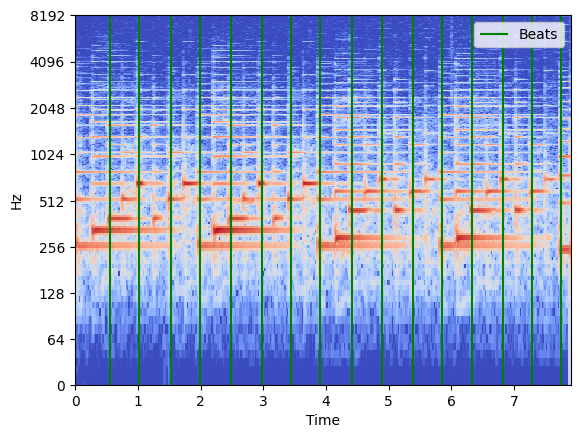

In [20]:
D = librosa.stft(y)
S = abs(D)
S_db = librosa.amplitude_to_db(S)
librosa.display.specshow(S_db, sr=sr, x_axis="time", y_axis="log")
plt.vlines(actual_estimated_beats, *plt.gca().get_ylim(), color="green", label="Beats")

plt.ylim(0, 8192)
plt.legend(loc="upper right")
plt.show()

In [21]:
clicks_actual = librosa.clicks(
    times=actual_estimated_beats, sr=sr, click_freq=1000, length=len(y)
)
ipd.Audio(y + clicks_actual, rate=sr)

Great. The beats estimated by our tracker sound **much more realistic**, and this is reflected in the numeric results too.

### More Evaluation Metrics ⏩

In this section, we've explored the following concepts:

- **Fair and Unfair Metrics**
- **True and False Positives and Negatives**
- **Precision and Recall**
- **F1-Score**

These evaluation metrics relate to machine learning models capable of performing **classification**. For other tasks, we may want to use different metrics. Here are a few examples:

#### Example 1: Speech Recognition 🔊

A common evaluation metric for **automatic speech recognition** systems is the **word error rate** (WER). The lower the WER, the better the system.

We can calculate WER by considering the following information:

- **Substitutions**: the number of words the system replaces from the ground truth
- **Deletions**: the number of words in the ground truth not detected by the system
- **Insertions**: the number of words detected by the system not present in the ground truth.

So, for instance, if our ground truth was:

`"this is the prediction, there is an other sample"`

And our system detected:

`"this is the reference, there is another one"`

We have the following:

- **Substitutions**: "prediction" $→$ "reference", "an" $→$ "another", "other" $→$ "one"
- **Deletions**: "sample" missing
- **Insertions**: none

We then calculate the word error rate as:

$$
WER = \dfrac{S + D + I}{N}
$$

where $N$ is the number of words in the reference.

Plugging in our values from the example:

$$
WER = \dfrac{3 + 1 + 0}{9} \approx 0.44
$$

The WER is a useful tool for comparing automatic speech recognition systems. However, it provides no detail on the **nature** of the error.

For more information on the WER, [see this article](https://huggingface.co/spaces/evaluate-metric/wer).

> **Good to know:** an alternative metric to WER is the Character Error Rate (CER). This is calculated in the same way as WER, but using individual **characters** (i.e., letters), rather than words.

#### Example 2: Object Recognition 🚗

Object recognition systems usually perform two tasks: **segmentation** and **classification**

1. **Segementation**: the system takes an image and assigns multiple **rectangular outlines**, each of which enclose a single object. We call these outlines **bounding boxes**.
2. **Classification**: every bounding box is then assigned a **label** based on the predicted target class.

<img src="https://www.peopleforai.com/wp-content/uploads/2023/08/AV_img_4_ann-trimmed-Bbox-lexicon-e1709636202717.jpg" width="600px"/>

> **Important**: when training an object recognition model, our ground truth usually consists of an image labelled by a human, with **pre-assigned bounding boxes**.

To evaluate the **segmentation performance**, typically we'll use the **intersection over union** (IoU). We calculate this by taking the **intersection area** of a predicted and ground truth bounding box. Let $P$ be our predicted bounding box and $G$ be our ground truth:

$$
IoU = \dfrac{|P \cap G|}{|P \cup G|}
$$

A higher IoU score indicates a **better match** between the predicted and ground truth bounding boxes. However, this metric only assesses the localization performance of an object recognition model: how accurately it can place bounding boxes.

To assess the **classification** performance, we can use modified versions of **precision**, **recall**, and **F1-score**. We can, for instance, calculate true positives as instances where the predicted class matches the ground truth class, **and** the IoU score between the predicted bounding box and the ground truth **exceeds a predefined IoU threshold.**


<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*lcOHAUK055skNCt4QmxV8g.png" width="600px"/>




#### Which Metric Should I Use? 🤔

Ultimately, the correct metric to use to evaluate a machine learning model will depend on a variety of factors, which may include:

1. **The dataset used** (size, qualities, class distribution)
2. **The learning paradigm** (unsupervised, supervised, self-supervised)
3. **Scientific conventions** (what metrics do other machine learning researchers use for this task?)
4. **Application objectives** (what questions are we trying to answer with this model?)
5. **Domain-specific requirements** (in healthcare, recall may be prioritized to avoid missing critical cases)
6. **Model interpretability** (simpler metrics may be preferred when results need to be explained to non-technical stakeholders)

## Interpretability 🧠

The last statement in the list above underlines an important point. Knowing *how well* a model performs is only part of the story. We also want to understand **why** the model makes certain predictions. This leads us to the second major topic of this notebook: **interpretability**.  

**Interpretability** means being able to explain a model's decisions in a way that humans can understand. For example:  
- Which classes does the model struggle with the most, or confuse with other classes?
- Which features (inputs) were most important in making a prediction?  

### TinySOL Revisited... 🌞

Let's return to the dataset we explored in the previous notebook on **Learning Paradigms**.

As a reminder, this dataset is called **TinySOL**, and it contains 2913 recordings of musical notes performed on 14 different instruments, ranging from tuba to saxophone.

> **If you're not familiar with the dataset**, check out the previous notebook.

Once again, we'll load the dataset again using `mirdata`:



In [22]:
# @title
tinysol = mirdata.initialize('tinysol')
tinysol.download()
tinysol.validate()

979MB [08:06, 2.11MB/s]                           
312kB [00:01, 231kB/s]                           
488kB [00:00, 1.63MB/s]                            
100%|██████████| 2913/2913 [00:05<00:00, 556.44it/s]


({'metadata': {}, 'tracks': {}}, {'metadata': {}, 'tracks': {}})

Now that we've downloaded our dataset, we can extract the same 6 features that we looked at in the previous notebook.

As a reminder, these are:

1. **spectral centroid**
2. **spectral bandwidth**
3. **spectral flatness**
4. **spectral rolloff**
5. **root-mean-square**
6. **zero-crossing rate**

We'll extract these features from every recording in TinySOL, and then scale them to the range 0-1.

Remember that this code might take a while to run, so please be patient!

> **Important**: if you are unsure what any of these features mean or how they are extracted, please refer to the **previous notebooks** where they are discussed in more detail.

In [23]:
# @title
def feature_extractor(waveform: np.ndarray, sr: float) -> np.ndarray:
    """
    Extracts temporal features from an audio signal.

    Returns a 2D array, where each row is a frame and each column is a feature
    """
    # Compute the spectrogram
    X_stft = librosa.stft(waveform, win_length=512, hop_length=256)
    spect = np.abs(librosa.amplitude_to_db(np.abs(X_stft)))

    # Extract every feature
    spectral_centroids = librosa.feature.spectral_centroid(S=spect,)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(S=spect,)
    spectral_flatness = librosa.feature.spectral_flatness(S=spect,)
    spectral_rolloff = librosa.feature.spectral_rolloff(S=spect,)
    rmse = librosa.feature.rms(S=spect,)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(waveform, frame_length=512, hop_length=256)

    # Stack the features to the shape (N_frames, N_features)
    return np.vstack([
        spectral_centroids,
        spectral_bandwidth,
        spectral_flatness,
        spectral_rolloff,
        rmse,
        zero_crossing_rate,
    ]).T


def process(track: tuple) -> np.ndarray:
    """
    Extract average features for a single recording.
    """
    # Extract the features for every frame: shape (N_frames, N_features)
    extracted = feature_extractor(track.audio[0], track.audio[1])
    # Average the features over all frames to create a vector: shape (N_features,)
    extracted_vector = np.mean(extracted, axis=0)
    return extracted_vector


def minmax_norm(feature: np.ndarray) -> np.ndarray:
    """
    Normalises a feature to have min(F) = 0, max(F) = 1
    """
    min_ = feature.min()
    max_ = feature.max()
    return (feature - min_) / (max_ - min_)


# Load up all the recordings from tinysol
all_recordings = tinysol.load_tracks()
# Initialise an empty list to store all the feature vectors
all_features = []

# Iterate over all the recordings: we use `Joblib` to parallelise the process
#  setting verbose=... increases how often we'll log our progress to the console
with Parallel(n_jobs=-1, verbose=5) as parallel:
    all_features = parallel(delayed(process)(track) for track in all_recordings.values())

# Stack all of the vectors into a matrix with shape (N_recordings, N_features)
feature_matrix = np.array(all_features)

# Normalise the features between 0 and 1
norm_feature_matrix = np.apply_along_axis(minmax_norm, 0, feature_matrix)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 342 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 702 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 936 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1206 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1512 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1854 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 2232 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 2646 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 2913 out of 2913 | elapsed:  6.5min finished


Let's split our data into **training** and **testing** splits, as we did in the previous notebook.

In [24]:
# @title
all_instrs = np.array([track.instrument_full for track in all_recordings.values()])
X_train, X_test, y_train, y_test = train_test_split(
    norm_feature_matrix, all_instrs,
    train_size=0.8,
    test_size=0.2,
    random_state=42,
    stratify=all_instrs
)

And now, let's train the simple neural network we introduced at the end of the previous notebook.

In [25]:
# @title
class SimpleInstrumentClassifier(torch.nn.Module):
    """
    A simple musical instrument classifier built in PyTorch.

    The model contains one linear layer to generate logits
    from an input feature vector.
    """

    def __init__(self, in_features: int, out_classes: int):
        """
        The __init__ method initialises the model.

        Inside it, we define the layers we want to use in the
        model, as well as the shape that they should take.

        Here, we define the number of input features that our
        linear layer should take in, and the number of output
        classes it should predict.
        """

        super().__init__()
        self.fc = torch.nn.Linear(in_features, out_classes)
        # Initialise the weights as with our numpy model
        torch.nn.init.normal_(self.fc.weight, mean=0.0, std=0.01)
        torch.nn.init.zeros_(self.fc.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        The .forward method defines the "forward pass".

        It takes in the raw feature vector, passes it through
        all the layers of the model, and returns the output.
        """
        logits = self.fc(x)
        return logits


# Define hyperparameters
learning_rate = 0.001
n_steps = 50000

# Create the model, loss function, and Adam optimiser
torch_model = SimpleInstrumentClassifier(in_features=6, out_classes=14)
loss_fn = torch.nn.CrossEntropyLoss()    # includes softmax
optim = torch.optim.Adam(torch_model.parameters(), lr=learning_rate)

# Move everything onto the GPU if it is available
device = "cuda" if torch.cuda.is_available() else "cpu"
torch_model.to(device)
loss_fn.to(device)

train_losses_torch = []
test_losses_torch = []

# This mapping converts our instrument names from strings to integers
str_to_int_mapping = {k: v for v, k in enumerate(np.unique(y_train))}

# Convert instrument labels from strings to integers
y_train_idxs = np.array([str_to_int_mapping[yt] for yt in y_train])
y_test_idxs = np.array([str_to_int_mapping[yt] for yt in y_test])

# Convert all numpy arrays to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_idxs, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_idxs, dtype=torch.long)

# Set our model to training mode
torch_model.train()

for n in range(n_steps):
    # Forward pass
    logits = torch_model(X_train_tensor)
    avg_loss = loss_fn(logits, y_train_tensor)

    # Backward pass
    optim.zero_grad()
    avg_loss.backward()
    optim.step()

    # Every 1000 steps, compute the test loss
    #  and print everything
    if n % 1000 == 0:
        # Forward pass with held-out data
        val_logits = torch_model(X_test_tensor)
        val_loss = loss_fn(val_logits, y_test_tensor)

        # No backward pass for held-out data

        test_losses_torch.append(val_loss.item())
        train_losses_torch.append(avg_loss.item())
        print(f"Training, step {n}/{n_steps}: train loss {round(avg_loss.item(), 3)}, test_loss {round(val_loss.item(), 3)}")


print("\n\n\n")
print("STARTING TESTING!")

# TESTING

# Set our model to evaluation mode
torch_model.eval()

# We use "no_grad" to not keep track of gradients
with torch.no_grad():
    logits = torch_model(X_test_tensor)
    loss = loss_fn(logits, y_test_tensor)
print(f"Test loss: {loss.item()}")

y_test_pred = torch.argmax(logits, axis=1).cpu().numpy()
acc = accuracy_score(y_test_idxs, y_test_pred)
print(f"Test accuracy: {acc}")

Training, step 0/50000: train loss 2.639, test_loss 2.636
Training, step 1000/50000: train loss 2.237, test_loss 2.241
Training, step 2000/50000: train loss 2.114, test_loss 2.125
Training, step 3000/50000: train loss 2.024, test_loss 2.042
Training, step 4000/50000: train loss 1.951, test_loss 1.976
Training, step 5000/50000: train loss 1.888, test_loss 1.918
Training, step 6000/50000: train loss 1.832, test_loss 1.866
Training, step 7000/50000: train loss 1.783, test_loss 1.821
Training, step 8000/50000: train loss 1.741, test_loss 1.781
Training, step 9000/50000: train loss 1.703, test_loss 1.745
Training, step 10000/50000: train loss 1.669, test_loss 1.713
Training, step 11000/50000: train loss 1.638, test_loss 1.683
Training, step 12000/50000: train loss 1.611, test_loss 1.656
Training, step 13000/50000: train loss 1.587, test_loss 1.632
Training, step 14000/50000: train loss 1.565, test_loss 1.61
Training, step 15000/50000: train loss 1.544, test_loss 1.59
Training, step 16000/50

### Interpreting Predictions with a Confusion Matrix 😖

To interpret our model, we can start by creating a special type of plot called a **confusion matrix**.

A confusion matrix helps us see how well our model is performing across **different classes.** Instead of just showing a single accuracy number, it shows where the model is making correct predictions and where it's getting things wrong. Each row represents the true labels (what the instrument actually is), and each column represents the predicted labels (what the model guessed). This makes it easier to interpret not just how accurate the model is, but also **what kinds of mistakes it tends to make**.

Let's use the `scikit-learn` implementation:

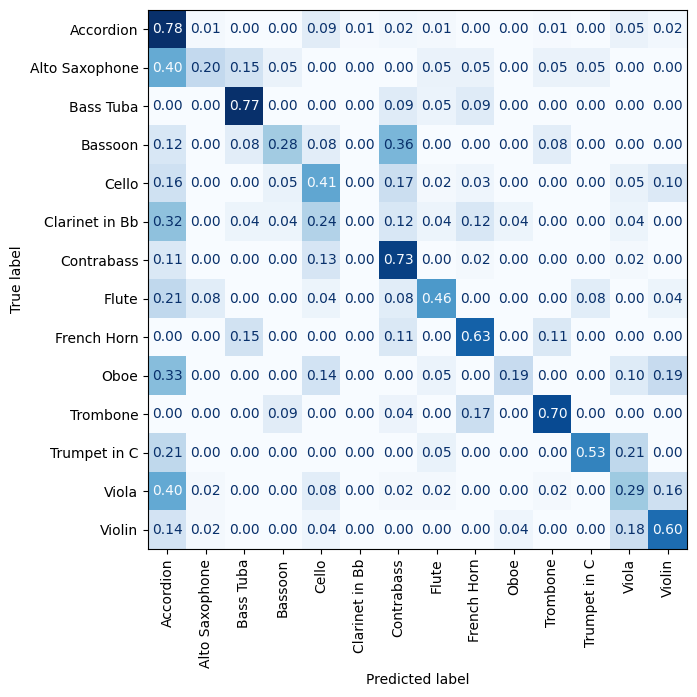

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
cm = ConfusionMatrixDisplay.from_predictions(
    y_test_idxs, y_test_pred,
    display_labels=np.unique(y_test),
    cmap="Blues",
    normalize="true",
    xticks_rotation=90,
    values_format=".2f",
    ax=ax,
    colorbar=False
)
plt.show()

#### Interpreting the Confusion Matrix 🤔

We read a confusion matrix by looking along the *y-axis* to see the **ground truth class** for a recording, and then scanning across to the *x-axis* to see the class the model **predicted**.

Let's start by looking at the **diagonal** (top left to bottom right). This shows us the accuracy of predictions for **each individual class**.

- Our model is the most accurate at identifying **Bass Tuba** (77% accurate) and **Accordion** (78% accurate) recordings
- Vice-versa, our model performs the worst when identifying recordings by the **Oboe** (19% accurate) and **Clarinet** (0% accurate).

> **Why do you think this might be?** What differences might exist between these instruments that makes it easier for the model to classify one, but not the other?

But a confusion matrix can also tell us **which classes the model confused with each other** - hence the name!

Let's start by looking at the **Bassoon row**. We can see that our model often confused recordings by this instrument for recordings by the **Contrabass** (double bass, the lowest string instrument). What might be similar between these instruments?

> **Hint:** think about the similar **range of pitches** that both instruments can play!

Finally, let's look at the **Accordion column** (i.e., the left-most column). We can see that, in many cases, the model is often **predicting Accordion** for non-Accordion recordings. As the Accordion is the **most popular class in the training dataset**, this might suggest that the model has simply learned to predict this, rather than capturing important patterns.

### Feature Importance 💪

A confusion matrix is a good way of interpreting our model in terms of the **classes that it is trying to predict**. An alternative method involves interpreting our model in terms of its **input features**. This allows us to discover **which features contribute the most towards accurate predictions**.

For our instrument classifier, this will allow us to understand, for instance, whether qualities like **spectral centroid** are more important to the character of an instrument like **zero-crossing rate**.

Alternatively, for a model that predicts whether someone is at risk of dehydration, we might discover that daily water intake is more important than time spent exercising, or that temperature outside has a bigger effect than amount of sleep.

#### Permutation Feature Importance  🔀

Recall that our model learns to predict an instrument based on **six features** extracted from a recording. What happens to our model if it is **prevented from using one of these features?** How much worse might its predictions become? This is the core idea behind **permutation feature importance**.

To calculate the permutation feature importance, we use this process:
1. Train a model using all of the features
2. Compute the accuracy when predicting the held-out test data using all of the features
3. Take a single feature, then **randomly shuffle its values** (permutation)
4. Predict the **testing data** again, and compute the drop in accuracy
5. Permute the feature again and again, and finally **average** the drop in accuracy over all iterations

> **Note:** we usually repeat the permutation a large number of times (over one thousand iterations is common) in order to control for any **noise** that randomisation might introduce. It's possible that different random orderings of a feature might lead to different results, so by repeating the permutation and averaging we make our test more **reliable**. You might see this type of test referred to as a **Monte Carlo simulation** or **permutation test**.

Let's try computing **permutation feature importance** for our trained instrument classifier. We'll start by permuting the first feature (**spectral centroid**).

In [47]:
n_iterations = 1000
all_acc_drops = []

for _ in tqdm(range(n_iterations), desc="Permuting feature..."):
    # Make a copy of the training features so we don't effect the underlying data
    X_test_tensor_copy = X_test_tensor.clone()

    # Generate N random indices
    rand_indices = torch.randperm(X_test_tensor_copy.shape[0])
    # Shuffle the feature using these indices
    X_test_tensor_copy[:, 0] = X_test_tensor_copy[rand_indices, 0]

    # Compute logits using the shuffled data
    with torch.no_grad():
        logits_iter = torch_model(X_test_tensor_copy)

    # Predict the class with this iteration
    y_test_pred_iter = torch.argmax(logits_iter, axis=1).cpu().numpy()

    # Compute the accuracy score for this iteration
    acc_iter = accuracy_score(y_test_idxs, y_test_pred_iter)

    # Compute the loss in accuracy for this iteration
    acc_iter_drop = abs(acc_iter - acc)
    all_acc_drops.append(acc_iter_drop)


Permuting feature...: 100%|██████████| 1000/1000 [00:01<00:00, 766.22it/s]


In [49]:
avg_sc_loss = np.mean(all_acc_drops) * 100
print("Average loss in accuracy when permuting spectral centroid: ", round(avg_sc_loss, 3), "%")

Average loss in accuracy when permuting spectral centroid:  20.532 %


Great: we can see that, when we do not use the spectral centroid feature to predict, our model becomes about **20% worse**.

#### Permutation Importance Algorithm 💻

We can write a general algorithm for permutation feature importance as follows:

- Inputs: fitted predictive model $m$ tabular dataset (training or
  validation) $D$.
- Compute the reference score $s$ of the model $m$ on data
  $D$ (for instance, the accuracy for a classifier).
- For each feature $j$ (column of $D$):

  - For each repetition $k \in {1, ..., K}$:

    - Randomly shuffle column $j$ of dataset $D$ to generate a
      corrupted version of the data named $\tilde{D}_{k,j}$.
    - Compute the score $s_{k,j}$ of model $m$ on corrupted data
      $\tilde{D}_{k,j}$.

  - Compute importance $i_j$ for feature $f_j$ defined as:

    $$
    i_j = s - \frac{1}{K} \sum_{k=1}^{K} s_{k,j}
    $$

This algorithm applies to any model, any dataset, and any evaluation function.

> **Further reading**: this algorithm is adapted from [the tutorial on **permutation feature importance**](https://scikit-learn.org/stable/modules/permutation_importance.html) created by the developers of `scikit-learn`


#### Comparing Feature Importances ⚖

Where permutation feature importance really shines is in **comparing multiple features**. So, let's calculate the importance of every feature:

In [50]:
n_iterations = 1000

feat_names = [
    "spectral_centroid",
    "spectral_bandwidth",
    "spectral_flatness",
    "spectral_rolloff",
    "root_mean_square",
    "zero_crossing_rate"
]
# We'll use this to keep track of our *global results* (all features)
all_feat_res = []

for feat_name, feat_idx in zip(feat_names, range(6)):
    # We'll use this to keep track of results for *this feature* only
    all_acc_drops = []

    for _ in tqdm(range(n_iterations), desc=f"Permuting feature {feat_name}..."):
        # Make a copy of the training features so we don't effect the underlying data
        X_test_tensor_copy = X_test_tensor.clone()

        # Generate N random indices
        rand_indices = torch.randperm(X_test_tensor_copy.shape[0])
        # Shuffle the feature using these indices
        X_test_tensor_copy[:, feat_idx] = X_test_tensor_copy[rand_indices, feat_idx]

        # Compute logits using the shuffled data
        with torch.no_grad():
            logits_iter = torch_model(X_test_tensor_copy)

        # Predict the class with this iteration
        y_test_pred_iter = torch.argmax(logits_iter, axis=1).cpu().numpy()

        # Compute the accuracy score for this iteration
        acc_iter = accuracy_score(y_test_idxs, y_test_pred_iter)

        # Compute the loss in accuracy for this iteration
        acc_iter_drop = abs(acc_iter - acc)
        all_acc_drops.append(acc_iter_drop)

    # Append the average result for this feature to the overall results list
    avg_feat_loss = np.mean(all_acc_drops) * 100
    all_feat_res.append(
        dict(
            feat=feat_name,
            importance=avg_feat_loss
        )
    )

Permuting feature zero_crossing_rate...: 100%|██████████| 1000/1000 [00:01<00:00, 897.37it/s]


Now, we can plot a **bar chart** showing the importance of each feature.

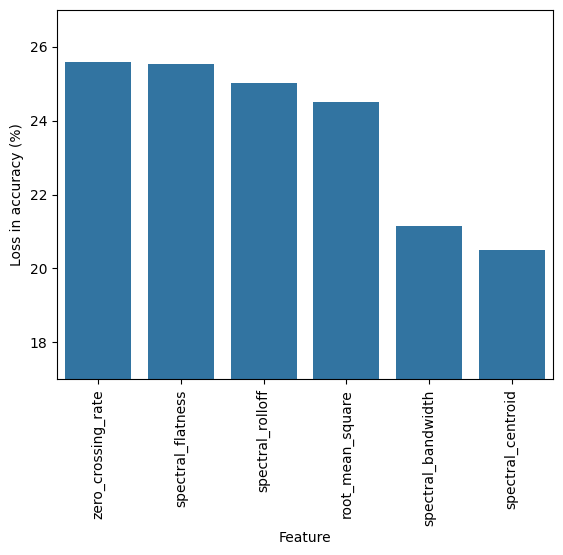

In [56]:
all_imports = (
    pd.DataFrame(all_feat_res)
    .sort_values(by="importance", ascending=False)
    .reset_index(drop=True)
)

g = sns.barplot(data=all_imports, x="feat", y="importance")
plt.gca().set(xlabel="Feature", ylabel="Loss in accuracy (%)", ylim=(17, 27))
plt.xticks(rotation=90)
plt.show()

#### Interpreting Feature Importance 🧠

Nice. By studying this plot, we can make the following claims about our feature set:

- **Zero crossing rate** and **spectral flatness** seem to be the *most important features* overall when classifying a musical instrument in TinySOL.
    - Recall from the previous notebook how these features capture how **noisy** a sound is
- Meanwhile, **spectral centroid** and **spectral bandwidth** seem to be the **least important features**.
    - These features capture the mean and variation of every column in the spectrogram.
- In general, however, the model **does use every feature**: none have a feature importance score less than 20%.


Taken together, we can possible conclude that our classifier seems to have learned to rely on **timbral features**, particularly how **noisy a sound is**, when classifying musical instruments. Vice versa, **pitch-related features** (including the average pitch of a tone) seem to be **less important** to the classifier.

> **Think about:** what else can we learn from this graph? How confident can we be in our model's decision making processes?




### Putting it Together: Combining Class and Feature Interpretations ➕

In the previous two sections, we explored how we can interpret a model by:
1. Considering the **individual classes** it is trained to predict;
2. Considering the **features** it uses to make predictions.

Let's now put both ideas together. We want to consider how **increases in a particular feature** effect the likelihood of the model **predicting a certain class**. For instance, does an **increase in zero-crossing rate** make the model more likely to predict one instrument than another?

#### Feature Sweep 🪥

We'll use the concept of a **feature sweep** to explore this idea. The process is as follows:

1. Let $X$ be a **uniform distribution** between the minimum and maximum value for a single feature
2. At every possible value of $x \in X$, predict the probability of each class using $x$, while setting the values for all other features **to their mean** (i.e., feature $y = \text{mean}(Y_i) \ \text{for} \ i \in |Y|$, where $Y$ is the matrix of features that does not include $X$)
3. Plot the change in the predicted probabilities for each class, for every value of $x \in X$

> **Hint:** you can think of this process a bit like making a **computer-generated sound**. Imagine you have a synthesiser with six different controls on it. You keep five of the controls the same, and then gradually increase the remaining control from 0 all the way to its maximum value. At regular points along the way, you ask the model to **predict the instrument** that could have made the sound. By doing this, we can see how **changing the control** effects the predictions of the model.

If this is unclear right now, it'll probably make more sense when written out in code. Let's start with the most important feature from our previous plot, `zero_crossing_rate`.

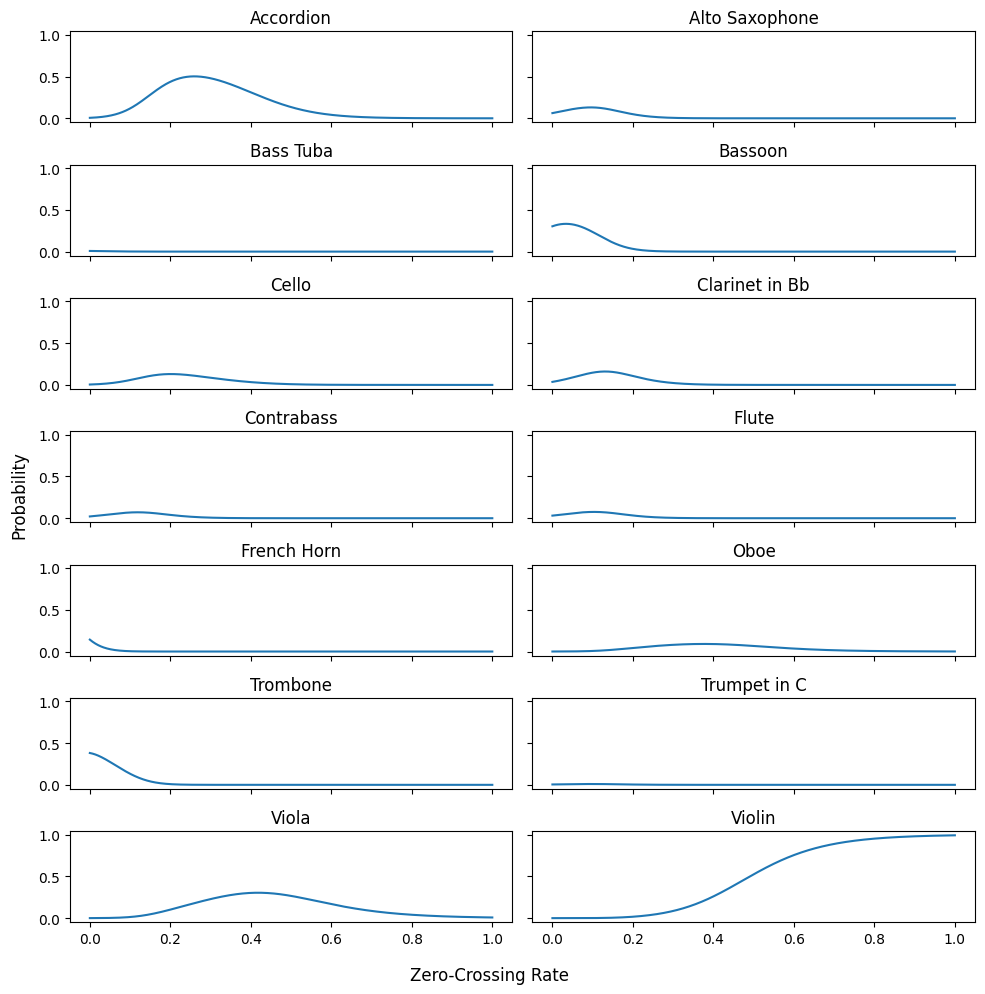

In [78]:
# Copy the tensor so we don't effect the underlying data
X_test_tensor_copy = X_test_tensor.clone()

# Create a uniform range between 0 and 1 and set to the target feature
x_ = torch.linspace(0, 1, X_test_tensor_copy.shape[0])
X_test_tensor_copy[:, 5] = x_

# Set all other features to their mean
for feat_idx in range(5):
    X_test_tensor_copy[:, feat_idx] = X_test_tensor_copy[:, feat_idx].mean()

# Compute logits for all items
with torch.no_grad():
    logits_mean = torch_model(X_test_tensor_copy)

# Softmax the logits for interpretability
smax = torch.nn.functional.softmax(logits_mean, dim=1)

# Construct plots
unique_classes = np.unique(y_test)
fig, ax = plt.subplots(
    nrows=unique_classes.shape[0] // 2,
    ncols=2,
    figsize=(10, 10),
    sharex=True,
    sharey=True
)

# Iterate through all classes and plot for this feature
for ax_, cls_idx in zip(ax.flatten(), range(smax.shape[1])):
    ax_.plot(x_, smax[:, cls_idx])
    ax_.set(xlabel="", ylabel="", title=unique_classes[cls_idx])

fig.supxlabel("Zero-Crossing Rate")
fig.supylabel("Probability")
plt.tight_layout()
plt.show()


#### Interpreting the Feature Sweep 🧠

We can learn a number of things from the plots above.

- When the zero-crossing rate is approximately 0 (i.e., the minimum value observed in the dataset), we are **about as equally likely** to predict either **Trombone** or **Bassoon**
- As the zero-crossing rate increases to $\approx 0.2$, **Accordion** becomes the most likely class
- Next, as we approach $\approx 0.4$, **Viola** becomes the most likely class
- Finally, as the zero-crossing rate approaches $\approx 0.5$, **Violin** is the most probable class.
- In fact, for values $> 0.8$, the model is **100% certain** that the instrument is **Violin**

Given that we know the zero-crossing rate reflects how **noisy** a sound is, this can tell us some interesting things relating to each instrument:
- Wind and brass instruments like the **Trombone** and **Bassoon** might produce pure-tone like sounds
- Whereas stringed instruments like the **Viola** and **Violin** require the use of a **bow**, which might introduce additional noise at the onset of a note

> **Think about:** what else can this plot tell us?

#### Sweeping Across All Features 🪥

As a final experiment, we can try repeating the process above, but sweeping individually across all features for a single instrument. This will let us see which values of each feature are associated with the instrument.

We'll start with plotting features for the **Accordion**, but you can try replacing the `target_instr` value below to test another instrument.

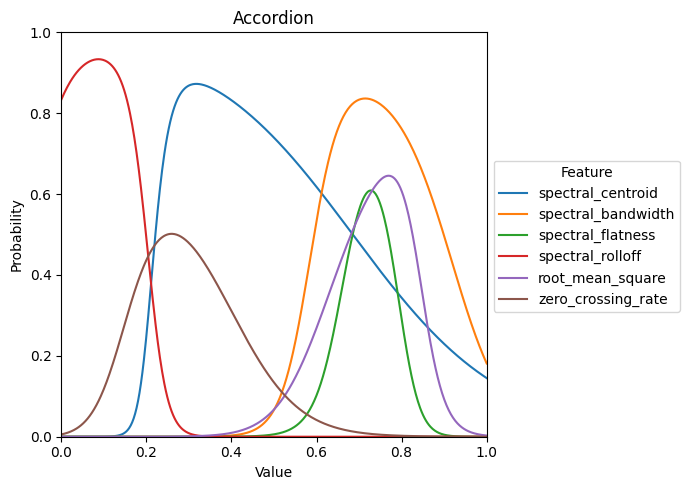

In [123]:
pred_values = torch.zeros_like((X_test_tensor))
target_instr = 0    # accordion: try replacing with another!

# Sweep across all features
for target_feat_idx in range(6):
    off_target_idxs = [i for i in range(6) if i != target_feat_idx]

    # Copy the tensor so we don't effect the underlying data
    X_test_tensor_copy = X_test_tensor.clone()

    # Create a uniform range between 0 and 1 and set to the target feature
    x_ = torch.linspace(0, 1, X_test_tensor_copy.shape[0])
    X_test_tensor_copy[:, target_feat_idx] = x_

    # Set all other features to their mean
    for ot_idx in off_target_idxs:
        X_test_tensor_copy[:, ot_idx] = X_test_tensor_copy[:, ot_idx].mean()

    # Compute logits for all items
    with torch.no_grad():
        logits_mean = torch_model(X_test_tensor_copy)

    # Softmax the logits for interpretability
    smax = torch.nn.functional.softmax(logits_mean, dim=1)

    # Add the probabilities for the target instrument to the tensor
    pred_values[:, target_feat_idx] = smax[:, target_instr]


# Construct plots
unique_classes = np.unique(y_test)
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(7, 5),
    sharex=True,
    sharey=True
)

# Plot each feature on the same axis, with a label
for feat_name, feat_idx in zip(feat_names, range(6)):
    ax.plot(x_, pred_values[:, feat_idx], label=feat_name)

# Plot aesthetics
ax.legend()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 0.7), title="Feature")
ax.set(
    xlabel="Value",
    ylabel="Probability",
    title=unique_classes[target_instr],
    ylim=(0, 1),
    xlim=(0, 1)
)
fig.tight_layout()
plt.show()


What can we learn from interpreting this plot? Here are a few possibilities:

- When **spectral rolloff** is below $0.1$, the model is highly confident that the instrument is the **Accordion**
- When **zero-crossing rate** and **spectral centroid** approach 0.2, the model becomes more confident in predicting the **Accordion**
- Finally, as **spectral bandwidth**, **spectral flatness**, and **root-mean-square** approach 0.7, the model becomes more likely to predict **Accordion**

## Summary 🤖🎹

In this notebook, we went beyond just knowing if a machine learning model is 'right' or 'wrong'. We explored how to truly understand its performance and why it makes certain decisions.

1.  **Evaluating Performance Beyond Accuracy**: We learned that a simple 'accuracy' score can sometimes be misleading. For our beat tracking example, a model could be 90% accurate but still sound terrible!
    -   We introduced **True Positives (TP)**, **False Positives (FP)**, and **False Negatives (FN)** to get a clearer picture of correct and incorrect predictions.
    -   This led us to **Precision** (how many of our predictions were actually correct) and **Recall** (how many of the actual correct things we managed to predict).
    -   The **F1-Score** combines Precision and Recall into a single value, giving a balanced view of a model's performance.

2.  **Interpreting Model Decisions**: Knowing *how* a model works is just as important as knowing *how well* it works.
    -   **Confusion Matrices**: We used these to see which specific instruments our classifier struggled with and which ones it often confused with others. This helped us understand patterns in its errors.
    -   **Feature Importance**: We discovered which characteristics (like 'zero-crossing rate' or 'spectral flatness') were most crucial for our instrument classifier to make its predictions. By randomly shuffling individual features, we could measure how much the model's performance dropped, indicating the importance of that feature.
    -   **Feature Sweeps**: This technique helped us see how changing a single feature's value (e.g., making a sound noisier) influenced the model's probability of identifying a specific instrument.

By using these tools, we can get a much deeper understanding of our machine learning models, helping us to build more reliable and trustworthy systems.